In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import csv

## Bring in the data

In [5]:
tropnames = {'etnakhta': u'\u0591', 'segol': u'\u0592', 'shalshelet': u'\u0593', 'katan': u'\u0594', 'gadol': u'\u0595',
             'tipkha': u'\u0596', 'revii': u'\u0597', 'tsinnorit': u'\u0598', 'pashta': u'\u0599', 'yetiv': u'\u059a', 'tevir': u'\u059b',
             'geresh': u'\u059c', 'gereshmukdam': u'\u059d', 'gershayim': u'\u059e', 'karnepara': u'\u059f', 'telishagedola': u'\u05a0',
             'pazer': u'\u05a1', 'munakh': u'\u05a3', 'mapakh': u'\u05a4', 'merkha': u'\u05a5',
             'merkhakfula': u'\u05a6', 'darga': u'\u05a7', 'kadma': u'\u05a8', 'telishaketana': u'\u05a9', 'yerakhbenyomo': u'\u05aa',
             'sofpasuk': u'\u05c3', 'zarka': u'\u05ae'}

# per wikipedia: Note that both marks have been wrongly named by Unicode.[5][6] Zarqa/tsinnor corresponds to Unicode
# "Hebrew accent zinor", code point U+05AE (where "zinor" is a misspelled form for tsinnor), while tsinnorit maps to
# "Hebrew accent zarqa", code point U+0598. 

In [23]:
sfarim = ['bereshit', 'shmot', 'vayikra', 'bmidbar', 'dvarim']

counts = {} # each member: {'sefer': 'bereshit', 'perek': 1, 'pasuk': 1, 'etnakhta': 1, 'segol': 0 ...}
for sefer in sfarim:
    counts[sefer] = {}
    tree = ET.parse(sefer + '.xml')
    root = tree.getroot() 
    prakim = root.findall('.//c')
    for perek in prakim:
        pereknum = int(perek.attrib['n'])
        if pereknum not in counts[sefer]: counts[sefer][pereknum] = {}
        psukim = perek.findall('v')
        for pasuk in psukim:
            pasuknum = int(pasuk.attrib['n'])
            if pasuknum not in counts[sefer][pereknum]:
                row = {name: 0 for name in tropnames.keys()}
                row['sefer'] = sefer
                row['pasuk'] = pasuknum
                row['perek'] = pereknum
                counts[sefer][pereknum][pasuknum] = row
            words = pasuk.findall('w')
            if 'wordcount' not in counts[sefer][pereknum][pasuknum]:
                counts[sefer][pereknum][pasuknum]['wordcount'] = len(words)
            else:
                counts[sefer][pereknum][pasuknum]['wordcount'] += len(words)
            for wordobj in words:
                word = wordobj.text
                for trop in tropnames:
                    if tropnames[trop] in word:
                        counts[sefer][pereknum][pasuknum][trop] += 1
            # counts.append(row)

In [24]:
flatcounts = [counts[s][pe][pa] for s in counts for pe in counts[s] for pa in counts[s][pe]]
df = pd.DataFrame(flatcounts)
df.set_index(['sefer', 'perek', 'pasuk'], inplace=True)
df = df.reindex(sfarim, level=0)

## Aggregate to inspect by sefer and perek

In [25]:
sefergroup = df.groupby(level=['sefer'])
sefermeans = sefergroup.mean()
sefersums = sefergroup.sum()

In [26]:
perekgroup = df.groupby(level=['sefer','perek'], sort=False)
perekmeans = perekgroup.mean()
perekmeans = perekmeans.reindex(sfarim, level=0) # sort=False isn't working, so...
perekmeans.dropna(inplace=True) # workaround for https://github.com/pydata/pandas/issues/9344
pereksums = perekgroup.sum()
pereksums = pereksums.reindex(sfarim, level=0) # sort=False isn't working, so...
pereksums.dropna(inplace=True) # workaround for https://github.com/pydata/pandas/issues/9344

In [132]:
sefermeans.T #[['telishaketana','telishagedola']]

sefer,bereshit,shmot,vayikra,bmidbar,dvarim
darga,0.165036,0.182193,0.199069,0.183863,0.217935
etnakhta,0.956295,0.946414,0.946449,0.892940,0.950991
gadol,0.114808,0.081616,0.064028,0.097750,0.072993
geresh,0.159165,0.191261,0.202561,0.173002,0.255474
gereshmukdam,0.000000,0.000000,0.001164,0.000000,0.000000
gershayim,0.073712,0.080791,0.088475,0.088441,0.113660
kadma,0.298108,0.336356,0.388824,0.337471,0.459854
karnepara,0.000000,0.000000,0.000000,0.000776,0.000000
katan,1.222440,1.218467,1.149010,1.052754,1.348279
mapakh,0.519243,0.541632,0.525029,0.439876,0.597497


## Moving average plots

In [34]:
rolling = pd.rolling_mean(df, 500, center=True)

In [15]:
seferticks = [0,df.index.get_loc(('shmot',1,1)),df.index.get_loc(('vayikra',1,1)),df.index.get_loc(('bmidbar',1,1)),df.index.get_loc(('dvarim',1,1))]

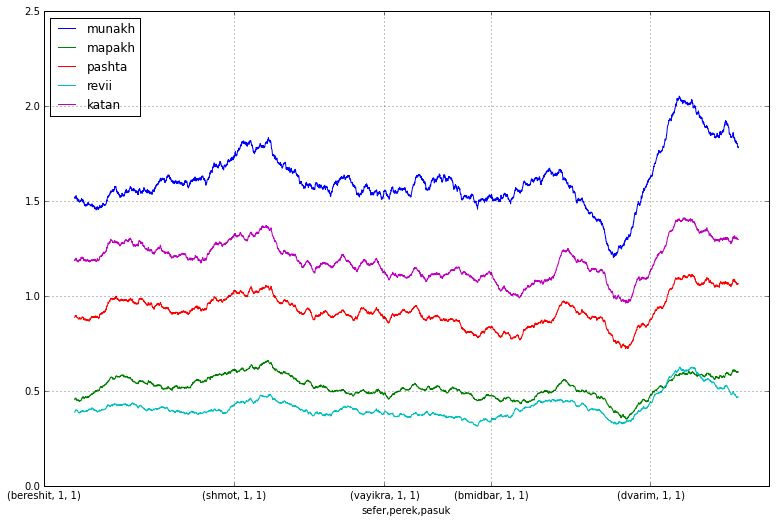

In [16]:
rolling[['munakh','mapakh','pashta','revii','katan']].plot(figsize=(13,8.5), xticks=seferticks)

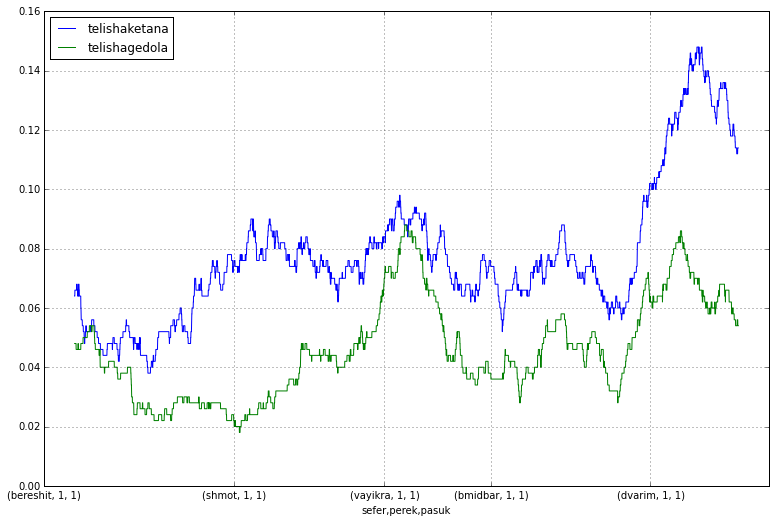

In [135]:
rolling[['telishaketana', 'telishagedola']].plot(figsize=(13,8.5), xticks=seferticks)

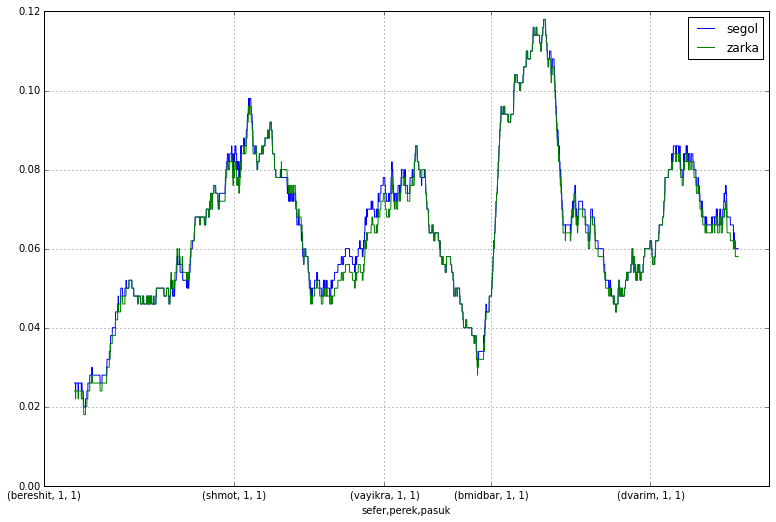

In [136]:
rolling[['segol', 'zarka']].plot(figsize=(13,8.5), xticks=seferticks)

In [37]:
df['wordcount_norm'] = df['wordcount']/max(df['wordcount'])

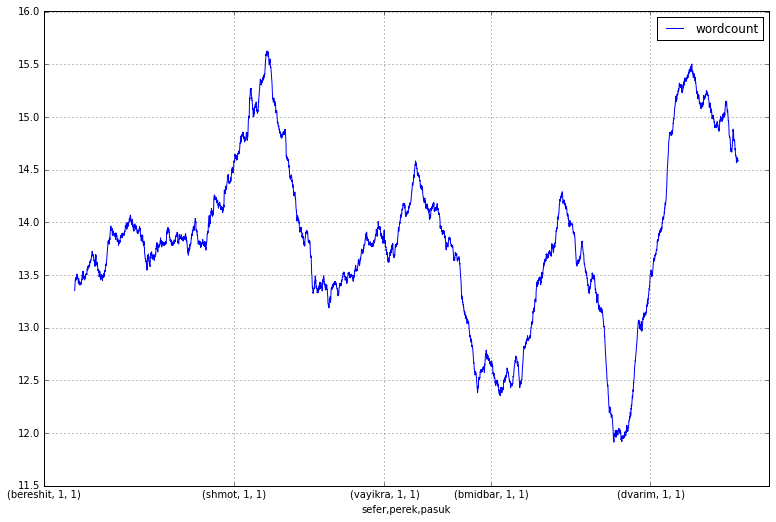

In [48]:
pd.rolling_mean(df[['wordcount']], 500, center=True).plot(figsize=(13,8.5), xticks=seferticks)

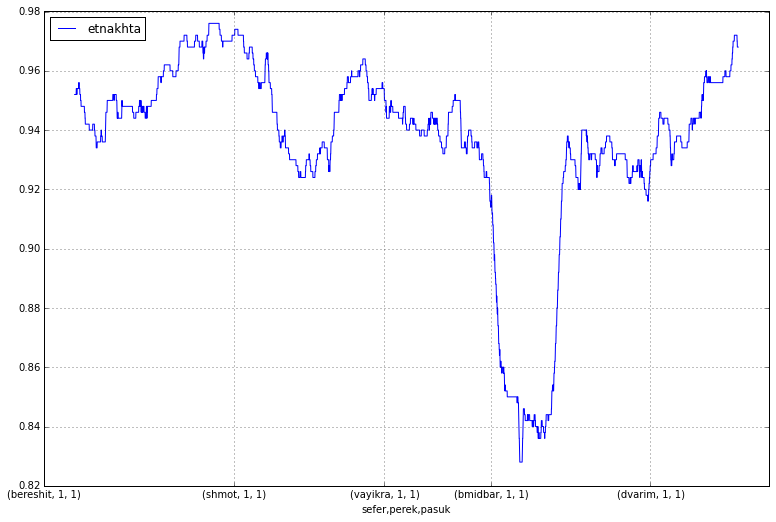

In [46]:
rolling[['etnakhta']].plot(figsize=(13,8.5), xticks=seferticks)

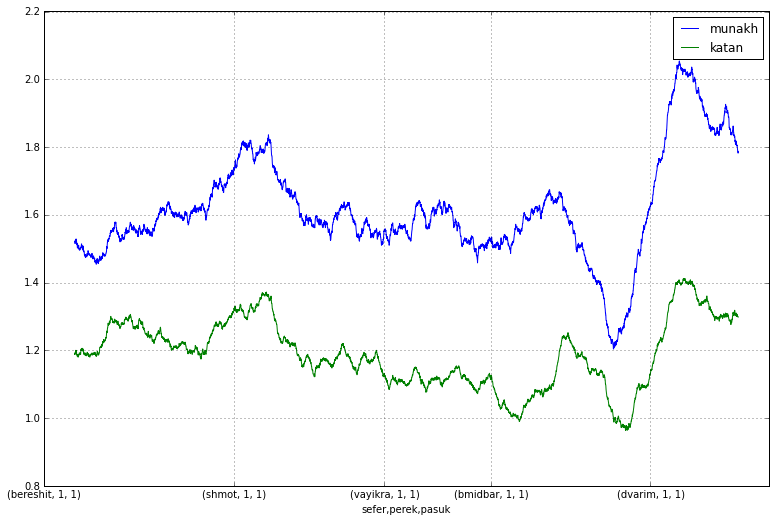

In [15]:
rolling[['munakh', 'katan']].plot(figsize=(13,8.5), xticks=seferticks)

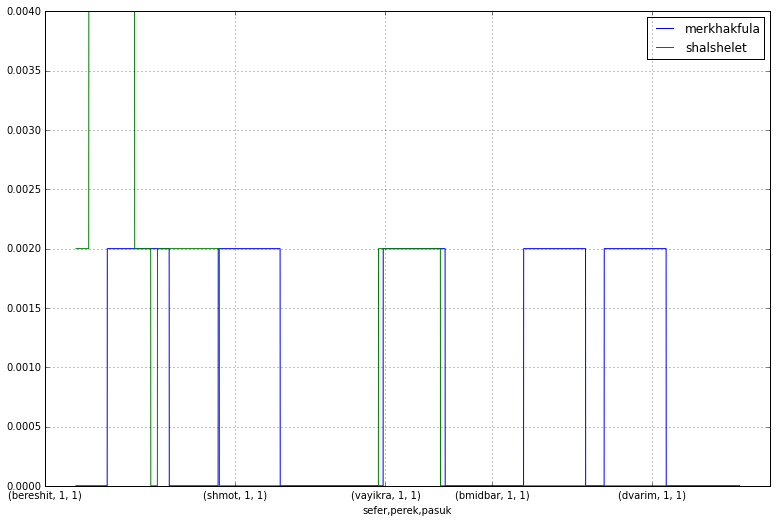

In [13]:
rolling[['merkhakfula', 'shalshelet']].plot(figsize=(13,8.5), xticks=seferticks)

## Looking for anomolies

In [120]:
df.loc['bmidbar'].query('etnakhta == 0')[['etnakhta']]

etnakhta
perek pasuk          
1     6             0
      7             0
      8             0
      9             0
      11            0
      12            0
      13            0
      14            0
      15            0
      48            0
2     1             0
3     5             0
      11            0
      14            0
      44            0
4     1             0
      17            0
      20            0
      21            0
5     1             0
      5             0
      9             0
      11            0
6     1             0
      22            0
      24            0
      25            0
      26            0
7     4             0
      14            0
...               ...
26    11            0
      46            0
      52            0
      53            0
27    5             0
      6             0
      15            0
28    1             0
29    18            0
      21            0
      24            0
      27            0
      30            0
      33            0
      37            0
31    1             0
      25            0
      33            0
      34            0
      44            0
      45            0
      46            0
      53            0
32    35            0
33    56            0
34    1             0
      16            0
      20            0
      21            0
35    9             0

[138 rows x 1 columns]

In [9]:
df.query('sofpasuk == 0')[['sofpasuk']]

sofpasuk
sefer    perek pasuk          
bereshit 27    3             0
         43    28            0
         49    11            0
shmot    2     5             0
         14    25            0
               29            0
         20    3             0
               4             0
               8             0
               9             0
               10            0
         34    6             0
         37    8             0
vayikra  18    17            0
         19    1             0
         26    7             0
bmidbar  7     32            0
               40            0
               55            0
               68            0
         25    19            0
dvarim   5     10            0
               12            0
         6     4             0
         9     20            0
         22    20            0
         25    9             0

In [122]:
df.query('tsinnorit > 0')[['tsinnorit']]

tsinnorit
sefer    perek pasuk           
bereshit 17    20             1
         47    29             1
shmot    6     6              1
         30    12             1
         36    2              1
vayikra  4     2              1
         20    2              1
bmidbar  20    19             1
dvarim   14    24             1
         31    7              1

## Histograms and other plots

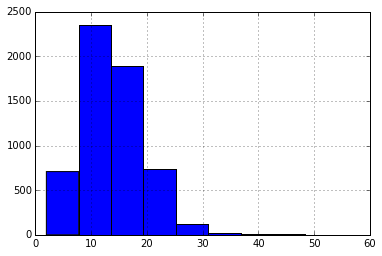

In [39]:
df['wordcount'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108908650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1087fc5d0>]], dtype=object)

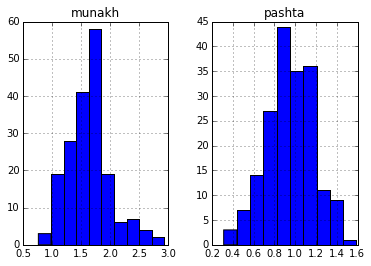

In [14]:
perekmeans[['munakh','pashta']].hist() #, bottom=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a17f250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10cb1fdd0>]], dtype=object)

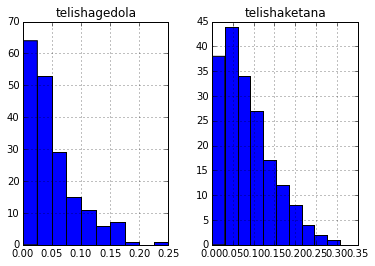

In [24]:
perekmeans[['telishaketana','telishagedola']].hist()

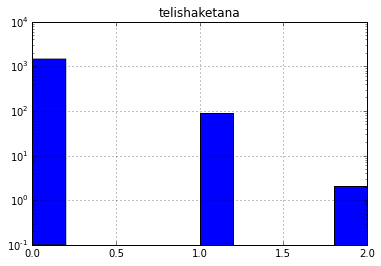

In [144]:
fig, ax = plt.subplots() 
df.loc['bereshit'][['telishaketana']].hist(ax=ax, bottom=0.1)
# df.loc['shmot'][['telishaketana']].hist(ax=ax, bottom=0.1)
ax.set_yscale('log')

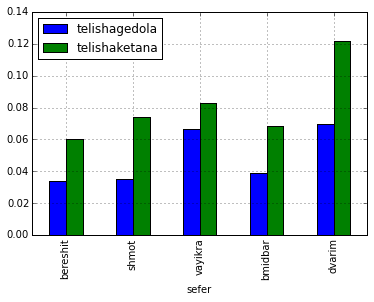

In [146]:
sefermeans[['telishagedola','telishaketana']].plot(by='sefer',kind='bar') # 'shalshelet', 'merkhakfula'

In [11]:
sum(df.loc['bereshit']['munakh'])

2401

In [12]:
2271+60

2331

## Output to CSV

In [37]:
# output to csv, just for giggles
with open('trop.csv', 'w') as outfile:
    dw = csv.DictWriter(outfile, counts[0].keys())
    dw.writeheader()
    dw.writerows(counts)